In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDelta 
from tqdm import tqdm

In [2]:
data = pd.read_csv("data/drinks/drinks.csv", usecols=["country", "wine_servings", "beer_servings"])
data.columns = ['country', 'wine', 'beer']
data.head()

,country,wine,beer
0,Afghanistan,0,0
1,Albania,89,54
2,Algeria,25,14
3,Andorra,245,312
4,Angola,217,45


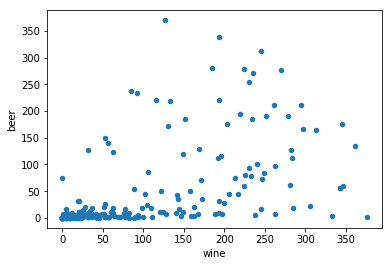

In [3]:
data.plot.scatter(x='wine', y='beer')
plt.show()

In [4]:
def model(drinks):
    cluster_means_pr = torch.tensor([[5.0, 5.0], [100.0, 250.0], [100.0, 100.0]])
    cluster_variance_pr = torch.eye(2) * 100
    prior_cluster_as = torch.tensor([1.0, 100.0, 100.0])
    ws = pyro.sample('ws', dist.Dirichlet(prior_cluster_as))
    cluster_means = pyro.sample('cluster_means', dist.MultivariateNormal(cluster_means_pr, cluster_variance_pr).to_event())
    cluster_variances = pyro.sample('cluster_variances', dist.HalfNormal(1.0).expand_by([3,2]).to_event()) + 1e-8
    with pyro.plate('drinks', dim=-1):
        cluster = pyro.sample('cluster', dist.Categorical(ws), infer=dict(enumerate='parallel'))
        pyro.sample('obs', dist.MultivariateNormal(cluster_means[cluster], torch.diag_embed(cluster_variances[cluster])), obs=drinks.float())

In [5]:
guide = AutoDelta(poutine.block(model, hide='cluster'))
wine = torch.tensor(data['wine'].values)
beer = torch.tensor(data['beer'].values)
drinks = torch.stack([wine, beer], dim=-1)
optim = Adam(dict(lr=1.0))
loss = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss)
svi.evaluate_loss(drinks)

1897142.5

In [6]:
progress = tqdm(range(2000))
for i in progress:
    loss = svi.step(drinks)
    progress.set_description(f"Epoch {i}: {loss}")

Epoch 1999: 15591.384765625: 100%|██████████| 2000/2000 [01:45<00:00, 19.17it/s] 


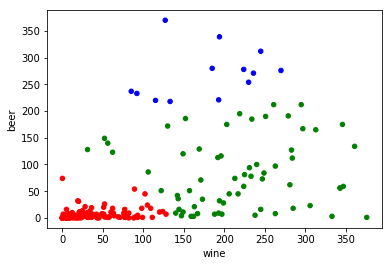

In [7]:
pred_cluster = torch.stack(
    [pyro.param('auto_ws')[cl] + 
     dist.MultivariateNormal(pyro.param('auto_cluster_means')[cl], 
                             torch.diag_embed(pyro.param('auto_cluster_variances')[cl]))
     .log_prob(drinks.float()) for cl in range(3)], dim=-1).argmax(dim=-1)
df = pd.DataFrame(dict(wine=data['wine'], beer=data['beer'], pred=pred_cluster.numpy()))
col = df['pred'].map({0: 'r', 1:'b', 2:'g'})
df.plot.scatter(x='wine', y='beer', color=col)